# Phase 2: The Rule-Based Engine (Days 8-14)

o Focus: Building the MVP Algorithm (Heuristic Model).

o Before we use Deep Learning, we start with a Weighted Scorecard. This is standard in banking.

- Task: Build a Python function that calculates a Score (300-850) based on weighted rules.
    - Stability (30%): Account age + Profile completeness.
    - Network (30%): "Who do you chat with?" (PageRank algorithm).
        - Advanced Task: Implement a simplified PageRank. If I chat with high-score users, my score goes up.
    - Behavior (40%): Frequency of posts + Lack of "toxic" flags (using the NLP model from the previous plan as a filter).
- Output: An API endpoint GET /score/{user_id} -> Returns 720 (Good).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import networkx as nx
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

df = pd.read_excel("data/detrust_dataset.xlsx")

#### 1. Sub-score Calculations

In [2]:
# 1. STABILITY SCORE COMPONENT (30%)
def calculate_stability_score(row):
    """Calculate stability score (30% weight)"""
    # Account age: older = better (0-40 points)
    age_score = max(0, min(row['account_age_days'] / 10, 40))
    
    # Profile completeness: complete = better (0-30 points)
    profile_score = int(row['complete_profile']) * 30
    
    # Verified email bonus (0-10 points)
    verified_score = int(row['verified_email']) * 10
    
    # Login consistency (0-20 points)
    total_logins = row['consistent_logins'] + row['random_logins']
    consistency_score = (
        (row['consistent_logins'] / total_logins) * 20
        if total_logins > 0 else 0
    )

    stability_score = (
        age_score +
        profile_score +
        verified_score +
        consistency_score
    )

    return min(stability_score, 100)

In [3]:
import networkx as nx

# pagerank_scores = nx.pagerank(G, alpha=0.85)

def calculate_network_score(row, pagerank_scores=None):
    """
    Network score based on observable social connectivity and influence.
    Score range: 0 to 80.
    """
    connections = max(0, row['connects_with_other_users'])
    account_age = max(0, row['account_age_days'])
    user_id = row['user_id']

    # 1. Social Reach (0–40)
    connection_score = min(connections * 4, 40)

    # 2. Network Maturity (0–25)
    stability_bonus = min(account_age / 40, 25)

    # 3. Social Influence (0–25)
    influence_score = 0
    if pagerank_scores is not None:
        influence_score = min(pagerank_scores.get(user_id, 0) * 100, 25)

    # 4. Isolation Risk Penalty (0–25)
    isolation_penalty = (5 - connections) * 5 if connections < 5 else 0

    # Total network score
    network_score = connection_score + stability_bonus + influence_score - isolation_penalty

    return max(0, min(network_score, 80))


In [4]:
# 3. BEHAVIOR SCORE COMPONENT (40%)

def calculate_behavior_score(row):
    """
    Behavior score based on responsiveness, activity quality, 
    and NLP-derived toxicity signals.

    Score range: 0 to 80
    """
    
    # Defensive guards
    avg_response = max(0, row['avg_response_time'])
    messages = max(0, row['messages_per_day'])
    toxic_count = max(0, row['toxic_message_count_prior'])
    spam_flag = int(row['spammy_chat_behavior'])

    if avg_response <= 5:
        response_score = 30
    elif avg_response <= 10:
        response_score = 25
    elif avg_response <= 20:
        response_score = 20
    elif avg_response <= 30:
        response_score = 15
    else:
        response_score = 10

    # Activity quality (0–25)
    if 10 <= messages <= 40:
        activity_score = 25
    elif 5 <= messages < 10 or 40 < messages <= 60:
        activity_score = 20
    elif messages < 5:
        activity_score = 15
    else:
        activity_score = 10  # Excessive → spam risk

    # Toxicity history (0–25)
    if toxic_count == 0:
        toxicity_score = 25
    elif toxic_count <= 2:
        toxicity_score = 20
    elif toxic_count <= 5:
        toxicity_score = 15
    elif toxic_count <= 10:
        toxicity_score = 10
    else:
        toxicity_score = 5

    # Spam penalty (0–20)
    spam_penalty = spam_flag * 20

    behavior_score = (
        response_score +
        activity_score +
        toxicity_score -
        spam_penalty
    )

    return max(0, min(behavior_score, 80))

In [5]:
# 4. CREDIT SCORE CALCULATOR (300-850 Scale)
def calculate_credit_score(row):
    """Final credit score (300 to 850), normalized components"""

    stability = calculate_stability_score(row)          # 0–100
    network = calculate_network_score(row) / 80 * 100   # normalize
    behavior = calculate_behavior_score(row) / 80 * 100 # normalize

    # Apply weights (30%, 30%, 40%)
    weighted_score = (
        stability * 0.30 +
        network * 0.30 +
        behavior * 0.40
    )
    
    # Scale from 0-100 to 300-850
    credit_score = 300 + (weighted_score / 100) * 550

    # Round to nearest integer
    return int(np.clip(credit_score, 300, 850))

In [ ]:
# Apply scoring to all users
print("🚀 Calculating credit scores for all users...")
df['credit_score'] = df.apply(calculate_credit_score, axis=1)

# Categorize scores
def categorize_score(score):
    score = int(score)
    if score >= 800: return "Excellent"
    elif score >= 740: return "Very Good"
    elif score >= 670: return "Good"
    elif score >= 580: return "Fair"
    elif score >= 500: return "Poor"
    else: return "Very Poor"

df['score_category'] = df['credit_score'].apply(categorize_score)

print("Scores calculated!")
print(f"\nScore Statistics:")
print(f"• Average: {df['credit_score'].mean():.1f}")
print(f"• Range: {df['credit_score'].min()} - {df['credit_score'].max()}")
print(f"• Good users avg: {df[df['target']==1]['credit_score'].mean():.1f}")
print(f"• Default users avg: {df[df['target']==0]['credit_score'].mean():.1f}")

# Save results
output_path = "data/detrust_scored.xlsx"
df.to_excel(output_path, index=False)
print(f"\nSaved to: {output_path}")

🚀 Calculating credit scores for all users...
Scores calculated!

Score Statistics:
• Average: 569.4
• Range: 313 - 819
• Good users avg: 692.3
• Default users avg: 446.8

Saved to: data/detrust_scored.xlsx


TESTING THE SCORING

SCORE DISTRIBUTION:
----------------------------------------
score_category
Very Poor    48780
Good         29009
Very Good    13886
Fair          6776
Poor          1245
Excellent      304
Name: count, dtype: int64

CORRELATION WITH TARGET: 0.810

SCORES BY TARGET CLASS:
----------------------------------------
Default: Mean=446.8, Median=425.0
Good: Mean=692.3, Median=720.0

CLASSIFICATION PERFORMANCE:
----------------------------------------


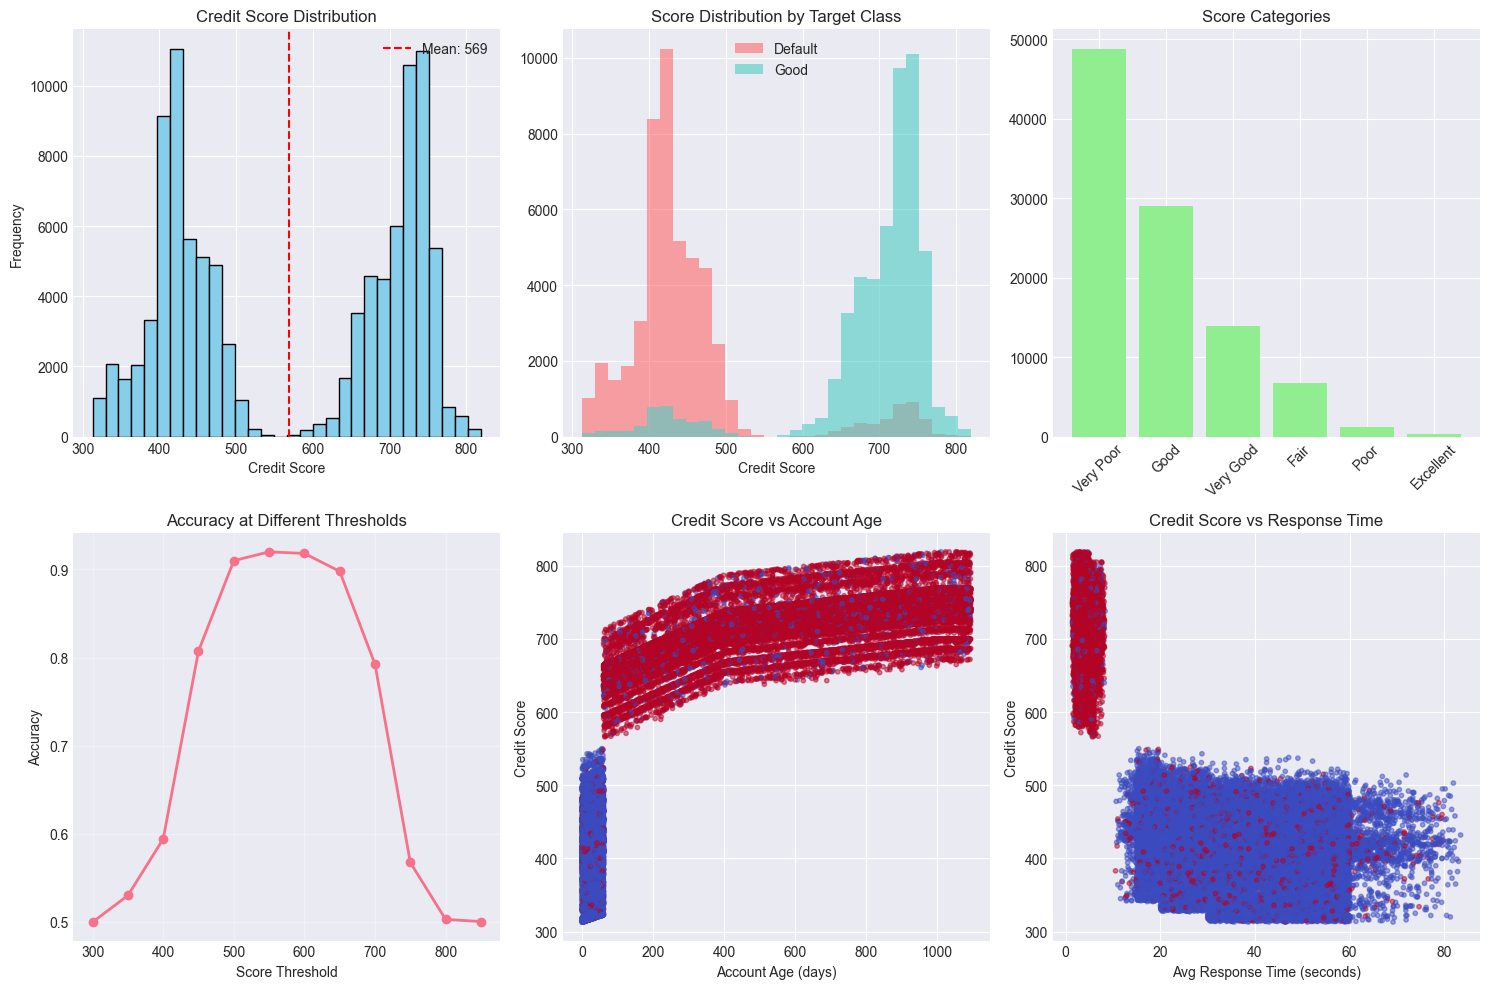

TESTING SPECIFIC CASES

BEST USER:
  Score: 819 (Excellent)
  Target: Good
  Account Age: 1057 days
  Verified Email: Yes

WORST USER:
  Score: 313 (Very Poor)
  Target: Default
  Account Age: 0 days
  Verified Email: No


In [ ]:
# TESTING THE SCORING SYSTEM

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

plt.style.use('seaborn-v0_8-darkgrid')

print("TESTING THE SCORING")

# 1. Basic Analysis
print("\nSCORE DISTRIBUTION:")
print("-" * 40)
print(df['score_category'].value_counts())

print(f"\nCORRELATION WITH TARGET: {df['credit_score'].corr(df['target']):.3f}")

# 2. Score by Target Class
print("\nSCORES BY TARGET CLASS:")
print("-" * 40)
for target_val in [0, 1]:
    label = "Default" if target_val == 0 else "Good"
    scores = df[df['target'] == target_val]['credit_score']
    print(f"{label}: Mean={scores.mean():.1f}, Median={scores.median():.1f}")

# 3. Classification Performance
print("\nCLASSIFICATION PERFORMANCE:")
print("-" * 40)

# Using 600 as threshold (common in credit scoring)
threshold = 600
df['prediction'] = (df['credit_score'] >= threshold).astype(int)

# 4. Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Score Distribution
axes[0,0].hist(df['credit_score'], bins=30, color='skyblue', edgecolor='black')
axes[0,0].axvline(df['credit_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["credit_score"].mean():.0f}')
axes[0,0].set_title('Credit Score Distribution')
axes[0,0].set_xlabel('Credit Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Plot 2: Score by Target
for target_val in [0, 1]:
    label = 'Default' if target_val == 0 else 'Good'
    color = '#FF6B6B' if target_val == 0 else '#4ECDC4'
    axes[0,1].hist(df[df['target']==target_val]['credit_score'], 
                   alpha=0.6, label=label, color=color, bins=30)
axes[0,1].set_title('Score Distribution by Target Class')
axes[0,1].set_xlabel('Credit Score')
axes[0,1].legend()

# Plot 3: Score Categories
category_counts = df['score_category'].value_counts()
axes[0,2].bar(category_counts.index, category_counts.values, color='lightgreen')
axes[0,2].set_title('Score Categories')
axes[0,2].tick_params(axis='x', rotation=45)

# Plot 4: ROC Curve (simplified)
thresholds = np.arange(300, 851, 50)
accuracies = []
for t in thresholds:
    pred = (df['credit_score'] >= t).astype(int)
    accuracies.append(accuracy_score(df['target'], pred))

axes[1,0].plot(thresholds, accuracies, marker='o', linewidth=2)
axes[1,0].set_title('Accuracy at Different Thresholds')
axes[1,0].set_xlabel('Score Threshold')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Score vs Account Age
axes[1,1].scatter(df['account_age_days'], df['credit_score'], 
                  alpha=0.5, s=10, c=df['target'], cmap='coolwarm')
axes[1,1].set_title('Credit Score vs Account Age')
axes[1,1].set_xlabel('Account Age (days)')
axes[1,1].set_ylabel('Credit Score')

# Plot 6: Score vs Response Time
axes[1,2].scatter(df['avg_response_time'], df['credit_score'], 
                  alpha=0.5, s=10, c=df['target'], cmap='coolwarm')
axes[1,2].set_title('Credit Score vs Response Time')
axes[1,2].set_xlabel('Avg Response Time (seconds)')
axes[1,2].set_ylabel('Credit Score')

plt.tight_layout()
plt.show()

# 5. Test Specific Cases
print("TESTING SPECIFIC CASES")

# Test cases: Best and worst scores
best_user = df.loc[df['credit_score'].idxmax()]
worst_user = df.loc[df['credit_score'].idxmin()]

print("\nBEST USER:")
print(f"  Score: {best_user['credit_score']} ({best_user['score_category']})")
print(f"  Target: {'Good' if best_user['target'] == 1 else 'Default'}")
print(f"  Account Age: {best_user['account_age_days']} days")
print(f"  Verified Email: {'Yes' if best_user['verified_email'] == 1 else 'No'}")
print("\nWORST USER:")
print(f"  Score: {worst_user['credit_score']} ({worst_user['score_category']})")
print(f"  Target: {'Good' if worst_user['target'] == 1 else 'Default'}")
print(f"  Account Age: {worst_user['account_age_days']} days")
print(f"  Verified Email: {'Yes' if worst_user['verified_email'] == 1 else 'No'}")

### 2. FastAPI

In [8]:
%%writefile api.py
from fastapi import FastAPI, HTTPException
import pandas as pd
from scoring import calculate_credit_score, categorize_score

app = FastAPI(
    title="DeTrust Phase 2 – Rule-Based Credit Scoring API",
    description="Rule-based, explainable credit score (300–850)",
    version="1.2"
)

DATA_PATH = "data/detrust_scored.xlsx"

try:
    df = pd.read_excel(DATA_PATH)

    # Extract numeric id from user_id like "user_3" → 3
    df["numeric_id"] = df["user_id"].str.extract(r'(\d+)').astype(int)

except FileNotFoundError:
    df = None
    print("⚠️ Dataset not found. API will compute scores on the fly.")


@app.get("/")
def root():
    return {"status": "DeTrust Phase 2 API is running"}


# Precomputed score
@app.get("/score/{user_id}")
def get_user_score(user_id: int):

    if df is None:
        raise HTTPException(status_code=500, detail="Dataset not loaded")

    # LOOKUP USING numeric_id
    user_row = df[df["numeric_id"] == user_id]

    if user_row.empty:
        raise HTTPException(status_code=404, detail=f"User ID {user_id} not found")

    row = user_row.iloc[0]
    score = int(row["credit_score"])
    category = categorize_score(score)

    return {
        "user_id": user_id,
        "credit_score": score,
        "category": category
    }

# Live scoring
@app.get("/score/live/{user_id}")
def get_user_score_live(user_id: int):

    if df is None:
        raise HTTPException(status_code=500, detail="Dataset not loaded")

    # LOOKUP USING numeric_id
    user_row = df[df["numeric_id"] == user_id]

    if user_row.empty:
        raise HTTPException(status_code=404, detail=f"User ID {user_id} not found")

    row = user_row.iloc[0]
    score = calculate_credit_score(row)

    return {
        "user_id": user_id,
        "credit_score": score,
        "category": categorize_score(score)
    }

Overwriting api.py
